# Gravitational Wave Simulator with Bilby

This notebook demonstrates how to generate gravitational wave signals for binary black holes (BBHs) using Bilby. It interfaces with the existing simulator structure (located in `./src/gw_simulator/simulator`) and allows you to switch between the PyCBC and Bilby implementations. 

Simply set the flag `SIMULATOR_TYPE` to either `'pycbc'` or `'bilby'` to choose your desired implementation.

In [4]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Import bilby
#!pip install bilby
import bilby

# Ensure the path to the simulator modules is set correctly
sys.path.insert(0, os.path.join(os.getcwd(), 'src/gw_simulator/simulator'))

# Import the existing PyCBC simulator and utility functions
from interface import GravitationalWaveBenchmarkSimulator as PyCBCSimulator
from util import Prior

# Flag to switch between implementations: 'pycbc' or 'bilby'
SIMULATOR_TYPE = 'bilby'  # change to 'pycbc' to use the PyCBC implementation

In [46]:
class BilbyGravitationalWaveBenchmarkSimulator:
    """
    Simulator model for gravitational waves using Bilby.
    Returns separate outputs for:
      - detector frame strains (i.e. the injected gravitational wave signal in the detector, with zero noise)
      - noise strains (the noise realization used)
    Both are provided in time and frequency domains.
    """
    def __init__(self,
                 duration=4.0,
                 sampling_frequency=2048,
                 ifo_names=['H1', 'L1', 'V1'],
                 waveform_approximant='IMRPhenomPv2'):
        self.duration = duration
        self.sampling_frequency = sampling_frequency
        self.ifo_names = ifo_names
        self.waveform_approximant = waveform_approximant
        
        # Set up default waveform arguments (adjust as needed)
        self.waveform_arguments = dict(
            waveform_approximant=self.waveform_approximant,
            reference_frequency=20.0,
            minimum_frequency=20.0
        )
        
        # Create a Bilby waveform generator using the LAL binary black hole source model
        self.waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
            duration=self.duration,
            sampling_frequency=self.sampling_frequency,
            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
            parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
            waveform_arguments=self.waveform_arguments
        )
        
        # Default geocentric time for injections.
        self.merger_time = 1126259462.4
        # Offset so that the merger is not at the very beginning of the time series.
        self.start_offset = 3.0

    def _simulate_gw(self, mass1, mass2):
        # Set up injection parameters (modify as needed)
        parameters = {
            'mass_1': float(mass1),
            'mass_2': float(mass2),
            'luminosity_distance': 400.0,  # in Mpc
            'theta_jn': 0.4,              # inclination angle (radians)
            'phase': 0.0,
            'geocent_time': self.merger_time,
            'ra': 1.95,
            'dec': -1.2,
            'psi': 0.0,
            'a_1': 0.0,
            'a_2': 0.0,
            'tilt_1': 0.0,
            'tilt_2': 0.0,
        }
        
        # Create interferometers.
        ifos = bilby.gw.detector.InterferometerList(self.ifo_names)
        
        # First, set the strain data from the PSD to generate a noise realization.
        # Store the noise separately for each interferometer.
        noise_data = {}
        for ifo in ifos:
            ifo.set_strain_data_from_power_spectral_density(
                sampling_frequency=self.sampling_frequency,
                duration=self.duration,
                start_time=self.merger_time - self.start_offset
            )
            # Copy the noise realization in both time and frequency domains.
            noise_td = ifo.strain_data.time_domain_strain.copy()
            noise_fd = ifo.strain_data.frequency_domain_strain.copy()
            noise_data[ifo.name] = {"td": noise_td, "fd": noise_fd}
        
        # Now inject the gravitational wave signal into the interferometers.
        ifos.inject_signal(parameters=parameters, waveform_generator=self.waveform_generator)
        
        # Retrieve the full (signal + noise) data and compute the pure signal (detector frame strain).
        strains = {}
        for ifo in ifos:
            full_td = ifo.strain_data.time_domain_strain
            full_fd = ifo.strain_data.frequency_domain_strain
            # Compute the pure injected signal by subtracting the noise realization.
            signal_td = full_td - noise_data[ifo.name]["td"]
            signal_fd = full_fd - noise_data[ifo.name]["fd"]
            strains[ifo.name] = {
                "detector": {"td": signal_td, "fd": signal_fd},
                "noise": {"td": noise_data[ifo.name]["td"], "fd": noise_data[ifo.name]["fd"]},
                "full": {"td": full_td, "fd": full_fd}  # full = detector + noise
            }
        return strains

    def forward(self, inputs, **kwargs):
        """
        Simulate gravitational wave signals for a batch of mass parameters.
        
        Args:
            inputs (torch.Tensor): A tensor of shape (batch_size, 2) containing mass parameters.
        
        Returns:
            dict: A dictionary with two keys ('detector' and 'noise'), each mapping to a sub-dictionary:
                  - "time": tensor of shape (batch_size, N_ifos, T_td)
                  - "frequency": tensor of shape (batch_size, N_ifos, T_fd)
        """
        batch_detector_td = []
        batch_detector_fd = []
        batch_noise_td = []
        batch_noise_fd = []

        # Loop over each sample in the batch.
        for mass_pair in inputs.view(-1, 2):
            strains = self._simulate_gw(mass_pair[0].item(), mass_pair[1].item())
            detector_td_list = []
            detector_fd_list = []
            noise_td_list = []
            noise_fd_list = []
            # Ensure ordering of interferometers follows self.ifo_names.
            for name in self.ifo_names:
                detector_td_list.append(torch.tensor(strains[name]["detector"]["td"]))
                detector_fd_list.append(torch.tensor(strains[name]["detector"]["fd"]))
                noise_td_list.append(torch.tensor(strains[name]["noise"]["td"]))
                noise_fd_list.append(torch.tensor(strains[name]["noise"]["fd"]))
            batch_detector_td.append(torch.stack(detector_td_list, dim=0))
            batch_detector_fd.append(torch.stack(detector_fd_list, dim=0))
            batch_noise_td.append(torch.stack(noise_td_list, dim=0))
            batch_noise_fd.append(torch.stack(noise_fd_list, dim=0))
        
        return {
            "detector": {
                "time": torch.stack(batch_detector_td, dim=0),
                "frequency": torch.stack(batch_detector_fd, dim=0)
            },
            "noise": {
                "time": torch.stack(batch_noise_td, dim=0),
                "frequency": torch.stack(batch_noise_fd, dim=0)
            }
        }

    def terminate(self):
        # Cleanup if needed.
        pass


In [47]:
class UniformMassPrior:
    """
    Uniform prior on two masses with the constraint mass1 > mass2.
    
    The allowed region is:
      lower <= mass2 < mass1 <= upper
      
    The sampling procedure generates two independent uniform samples in [lower, upper]
    and then sorts them so that mass1 is the maximum (first element) and mass2 the minimum (second element).
    
    The log probability is constant (2/(upper - lower)²) over the allowed region.
    """
    def __init__(self, lower: float, upper: float):
        self.lower = lower
        self.upper = upper
        # The constant density for a uniform distribution over the triangle of area (upper-lower)²/2.
        self.log_density = torch.log(torch.tensor(2.0 / ((upper - lower) ** 2)))
    
    def sample(self, sample_shape=torch.Size((1,))):
        """
        Draw samples from the constrained uniform prior.
        
        Args:
            sample_shape (torch.Size or tuple): Shape of samples to generate (default is one sample).
            
        Returns:
            torch.Tensor: A tensor of shape (*sample_shape, 2) with mass1 and mass2.
        """
        # Draw two independent samples in [0,1]
        samples = torch.rand(*sample_shape, 2)
        # Scale them to [lower, upper]
        samples = self.lower + (self.upper - self.lower) * samples
        # Sort along the last dimension in ascending order
        sorted_samples, _ = torch.sort(samples, dim=-1)
        # Rearrange so that mass1 (largest) is first and mass2 (smallest) is second
        mass1 = sorted_samples[..., 1]
        mass2 = sorted_samples[..., 0]
        return torch.stack([mass1, mass2], dim=-1)
    
    def log_prob(self, sample: torch.Tensor):
        """
        Evaluate the log-probability of a given sample.
        
        Args:
            sample (torch.Tensor): A tensor of shape (..., 2) where the first column is mass1 and second mass2.
            
        Returns:
            torch.Tensor: Log probability (scalar or tensor) for the sample. Returns -inf if constraints are violated.
        """
        m1 = sample[..., 0]
        m2 = sample[..., 1]
        # Check bounds and constraint: mass1 > mass2
        valid = (m1 >= self.lower) & (m1 <= self.upper) & (m2 >= self.lower) & (m2 <= self.upper) & (m1 > m2)
        # Assign constant log density if valid; otherwise, return -infinity
        log_p = torch.where(valid, self.log_density, torch.tensor(float('-inf')))
        return log_p

# Example usage:
prior = UniformMassPrior(lower=10.0, upper=80.0)
sample = prior.sample((5,))  # Draw 5 samples
print("Sampled masses (mass1, mass2):\n", sample)
print("Log probability of samples:\n", prior.log_prob(sample))


Sampled masses (mass1, mass2):
 tensor([[34.1575, 16.8729],
        [54.7003, 36.0066],
        [75.9404, 68.6485],
        [27.8020, 17.0390],
        [33.7039, 15.8913]])
Log probability of samples:
 tensor([-7.8038, -7.8038, -7.8038, -7.8038, -7.8038])


Text(0, 0.5, 'mass2')

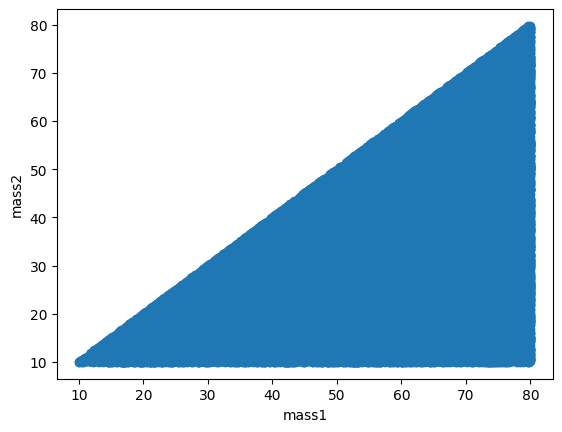

In [53]:
masses = prior.sample((100_000,))
plt.scatter(masses[:, 0], masses[:, 1])
plt.xlabel("mass1")
plt.ylabel("mass2")

DOMAIN: detector
  time shape: torch.Size([1, 3, 8192])
  frequency shape: torch.Size([1, 3, 4097])
DOMAIN: noise
  time shape: torch.Size([1, 3, 8192])
  frequency shape: torch.Size([1, 3, 4097])


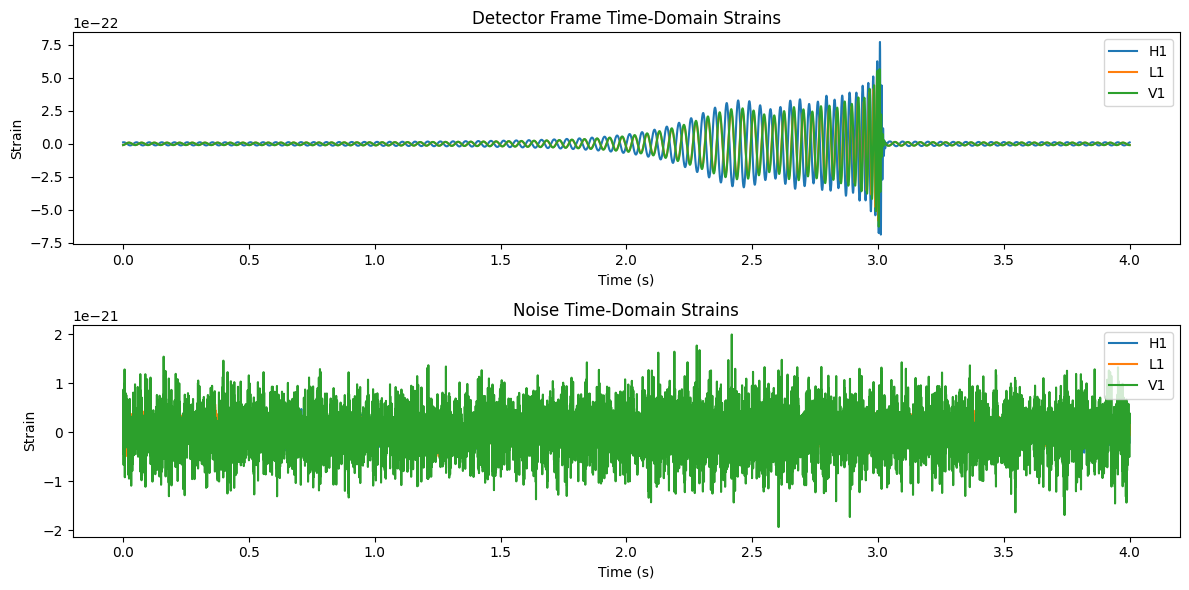

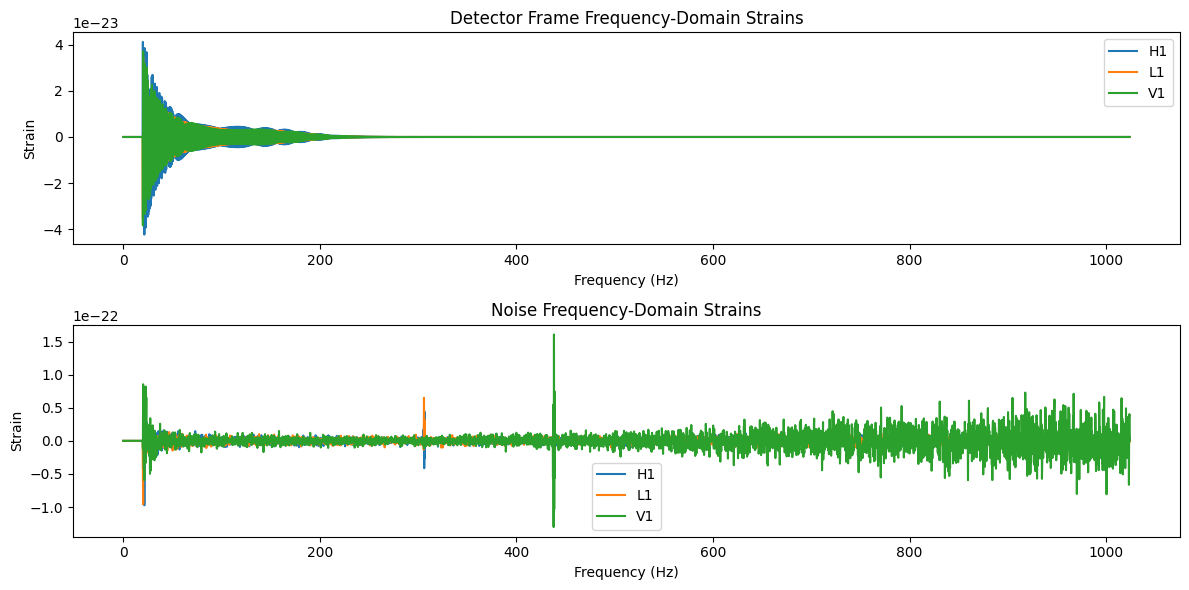

In [48]:
# Instantiate the simulator based on the selected implementation
if SIMULATOR_TYPE.lower() == 'bilby':
    simulator = BilbyGravitationalWaveBenchmarkSimulator()
elif SIMULATOR_TYPE.lower() == 'pycbc':
    simulator = PyCBCSimulator()
else:
    raise ValueError(f"Unknown simulator type: {SIMULATOR_TYPE}")

bilby.utils.logger.setLevel("ERROR")

# Draw a sample pair of masses from the prior
# (Using the custom UniformMassPrior since the original Prior had device issues)
prior = UniformMassPrior(lower=10.0, upper=80.0)
mass_samples = prior.sample((1,))  # sample one set (shape: (1, 2))

# Run the simulation
simulated_strains = simulator.forward(mass_samples)

# Print shapes for debugging
for domain in simulated_strains.keys():
    print(f"DOMAIN: {domain}")
    for subdomain in simulated_strains[domain].keys():
        print(f"  {subdomain} shape: {simulated_strains[domain][subdomain].shape}")

# For the bilby simulator output, we now have a dictionary with keys 'detector' and 'noise'
# Each of those is a dict with keys 'time' and 'frequency'
detector_time_strains = simulated_strains["detector"]["time"][0].numpy()  # (N_ifos, T_td)
detector_freq_strains = simulated_strains["detector"]["frequency"][0].numpy()  # (N_ifos, T_fd)

noise_time_strains = simulated_strains["noise"]["time"][0].numpy()  # (N_ifos, T_td)
noise_freq_strains = simulated_strains["noise"]["frequency"][0].numpy()  # (N_ifos, T_fd)

# Plot time-domain strains for detector frame and noise
time_array = np.linspace(0, simulator.duration, detector_time_strains.shape[1])
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
for i, name in enumerate(simulator.ifo_names):
    plt.plot(time_array, detector_time_strains[i], label=name)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Detector Frame Time-Domain Strains')
plt.legend()

plt.subplot(2, 1, 2)
for i, name in enumerate(simulator.ifo_names):
    plt.plot(time_array, noise_time_strains[i], label=name)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Noise Time-Domain Strains')
plt.legend()

plt.tight_layout()
plt.show()

# Plot frequency-domain strains for detector frame and noise
freq_bins = detector_freq_strains.shape[1]
frequency_array = np.linspace(0, simulator.sampling_frequency / 2, freq_bins)
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
for i, name in enumerate(simulator.ifo_names):
    plt.plot(frequency_array, detector_freq_strains[i], label=name)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.title('Detector Frame Frequency-Domain Strains')
plt.legend()

plt.subplot(2, 1, 2)
for i, name in enumerate(simulator.ifo_names):
    plt.plot(frequency_array, noise_freq_strains[i], label=name)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.title('Noise Frequency-Domain Strains')
plt.legend()

plt.tight_layout()
plt.show()
